<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/Spacegroup_specific_endeavours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
# Import
from mp_api.client import MPRester
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
from pymatgen.core.structure import Structure
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element
import time

In [3]:
# You might need to reinstall the library manually, imports ans pip install:
!pip install mp_api
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
with MPRester("VlQ1oWGAXlhWiKRkPOk5q1cP8dNS6mIu") as mpr:
  #Please edit features you want to filter from inside the search() command. for example:
  example_docs = mpr.materials.summary.search(spacegroup_number = 221, num_sites = 5)


Retrieving SummaryDoc documents:   0%|          | 0/1458 [00:00<?, ?it/s]

In [92]:
Element.from_Z(89).van_der_waals_radius

2.47

In [93]:
material_positions_frac = []
material_positions = []
bandgaps = []
elements_f_l = []
for m in example_docs:
  single_material_positions = []
  single_material_frac_positions = []
  elements_l = []
  for site in m.structure.sites:
    frac_coords = site.frac_coords
    single_material_frac_positions.append(site.frac_coords)
    single_material_positions.append(site.coords)
    elements_l.append(site.specie.number)

  material_positions_frac.append(single_material_frac_positions)
  material_positions.append(single_material_positions)
  bandgaps.append(m.band_gap)
  elements_f_l.append(elements_l)

In [94]:
all_material = []

for group in material_positions_frac:
  unique_positions = []
  for coord in group:
      # Round to 4 decimal places to eliminate noise
      rounded = tuple(np.round(coord % 1, 4))  # mod 1 ensures coords are in [0, 1)
      unique_positions.append(rounded)
  all_material.append(unique_positions.copy())

In [151]:
df = pd.DataFrame(list(zip(material_positions_frac, material_positions, bandgaps, elements_f_l)),
               columns =['all_material', 'material_positions', 'bandgaps', 'elements'])

In [152]:
vdw_values = []
s_numbers= []
for values in df['elements']:

  vdw_values.append([Element.from_Z(number).van_der_waals_radius for number in values])
  # electron_p_number = [get_outermost_p_orbitals(number) for number in values]
  electron_s_number = [get_outermost_s_orbitals(number) for number in values]
  s_numbers.append(electron_s_number)



In [128]:
values

[89, 13, 8, 8, 8]

In [153]:
df = pd.DataFrame(list(zip(material_positions_frac, material_positions, bandgaps, elements_f_l, vdw_values, s_numbers )),
               columns =['all_material', 'material_positions', 'bandgaps', 'elements', ' vdw_values', 's_numbers'])

In [154]:
df.values[0][4]

[2.47, 1.84, 1.52, 1.52, 1.52]

In [155]:
df

,all_material,material_positions,bandgaps,elements,vdw_values,s_numbers
0,"[[-0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5,...","[[0.0, 0.0, 0.0], [1.9293169350000001, 1.92931...",4.1024,"[89, 13, 8, 8, 8]","[2.47 ang, 1.84 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]"
1,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.860834, 1.860834, 1.86083...",0.8071,"[89, 5, 8, 8, 8]","[2.47 ang, 1.92 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]"
2,"[[-0.0, -0.0, -0.0], [0.5, 0.5, 0.5], [0.5, 0....","[[0.0, 0.0, 0.0], [1.97214345, 1.97215113, 1.9...",2.0031,"[89, 24, 8, 8, 8]","[2.47 ang, 2.06 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 1, 2, 2, 2]"
3,"[[0.0, 0.0, 0.0], [0.499998, 0.499998, 0.49999...","[[0.0, 0.0, 0.0], [1.9566577983375, 1.95665779...",0.0000,"[89, 29, 8, 8, 8]","[2.47 ang, 1.96 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 1, 2, 2, 2]"
4,"[[-0.0, 0.0, 0.0], [0.499998999999999, 0.49999...","[[0.0, 0.0, 0.0], [1.9767808564303762, 1.97677...",0.9888,"[89, 26, 8, 8, 8]","[2.47 ang, 2.04 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]"
...,...,...,...,...,...,...
1453,"[[0.0, 0.0, 0.0], [-0.0, 0.5, 0.5], [0.5, -0.0...","[[0.0, 0.0, 0.0], [0.0, 2.03775825, 2.03775825...",0.0000,"[40, 44, 44, 44, 6]","[2.23 ang, 2.13 ang, 2.13 ang, 2.13 ang, 1.7 ang]","[2, 1, 1, 1, 2]"
1454,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.8317364999999994, 1.83173...",0.0000,"[40, 14, 8, 8, 8]","[2.23 ang, 2.1 ang, 1.52 ang, 1.52 ang, 1.52 ang]","[2, 2, 2, 2, 2]"
1455,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.9295495, 1.9295495, 1.929...",0.0000,"[40, 22, 8, 8, 8]","[2.23 ang, 2.11 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]"
1456,"[[0.5, 0.5, 0.5], [0.0, 0.0, 0.0], [0.5, 0.5, ...","[[2.106323, 2.106323, 2.106323], [0.0, 0.0, 0....",0.0000,"[40, 81, 8, 8, 8]","[2.23 ang, 1.96 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]"


In [99]:
import numpy as np

def find_wyckoff_1b_3c_indices(coords):
    # Normalize and round for matching
    rounded_coords = [tuple(np.round(np.array(c) % 1, 6)) for c in coords]

    wyckoff_1b = (0.5, 0.5, 0.5)
    wyckoff_3c_list = [
        (0.5, 0.5, 0.0),
        (0.5, 0.0, 0.5),
        (0.0, 0.5, 0.5),
    ]

    # Find index of 1b
    try:
        i1b = rounded_coords.index(wyckoff_1b)
    except ValueError:
        i1b = None

    # Find index of any 3c
    i3c = None
    for w3c in wyckoff_3c_list:
        if w3c in rounded_coords:
            i3c = rounded_coords.index(w3c)
            break

    both_found = i1b is not None and i3c is not None

    return i1b, i3c, both_found

In [133]:

def get_outermost_p_orbitals(atomic_number):
    el = Element.from_Z(atomic_number)
    config = el.full_electronic_structure  # [(orbital_label, l, electrons)]

    p_orbs = [(orb, e) for orb, l, e in config if l == 'p']
    highest_p = max(p_orbs, key=lambda x: x[0])  # x[0]

    return highest_p[1]


def get_outermost_s_orbitals(atomic_number):
    el = Element.from_Z(atomic_number)
    config = el.full_electronic_structure  # [(orbital_label, l, electrons)]

    s_orbs = [(orb, e) for orb, l, e in config if l == 's']
    highest_s = max(s_orbs, key=lambda x: x[0])  # x[0]

    return highest_s[1]

In [156]:
distances = []
band_gaps = []
elements = []
electrons_1b = []
electrons_3c = []
van_der_waals_radius_sum = []
for data in df.values:
  pos1b, pos3c, both = find_wyckoff_1b_3c_indices(data[0])
  if both:
    distance = np.linalg.norm(data[1][pos1b] - data[1][pos3c])
    distances.append(distance)
    band_gaps.append(data[2])
    van_der_waals_radius_sum.append(data[4][pos1b] + data[4][pos3c])
    electrons_1b.append(data[5][pos1b])
    electrons_3c.append(data[5][pos3c])





In [157]:
van_der_waals_radius_sum = np.array(van_der_waals_radius_sum)
distances = np.array(distances)

overlap = van_der_waals_radius_sum - distances

In [183]:
created_lin = electrons_1b / overlap

In [184]:
df = pd.DataFrame(list(zip(distances, van_der_waals_radius_sum, bandgaps, overlap,created_lin,  electrons_1b, electrons_3c)),
                  columns =['distance', 'van_der_waals_radius_sum', 'bandgaps', 'overlap','created_lin', 'electrons_1b', 'electrons_3c'])

In [185]:
df.corr()

,distance,van_der_waals_radius_sum,bandgaps,overlap,created_lin,electrons_1b,electrons_3c
distance,1.000000,0.855552,0.012986,-0.252693,0.273271,0.163469,0.034490
van_der_waals_radius_sum,0.855552,1.000000,0.032738,0.284723,-0.048676,0.127511,-0.059871
bandgaps,0.012986,0.032738,1.000000,0.037139,-0.044642,-0.017151,-0.034013
overlap,-0.252693,0.284723,0.037139,1.000000,-0.596961,-0.064378,-0.175753
created_lin,0.273271,-0.048676,-0.044642,-0.596961,1.000000,0.815286,0.025560
electrons_1b,0.163469,0.127511,-0.017151,-0.064378,0.815286,1.000000,-0.073992
electrons_3c,0.034490,-0.059871,-0.034013,-0.175753,0.025560,-0.073992,1.000000


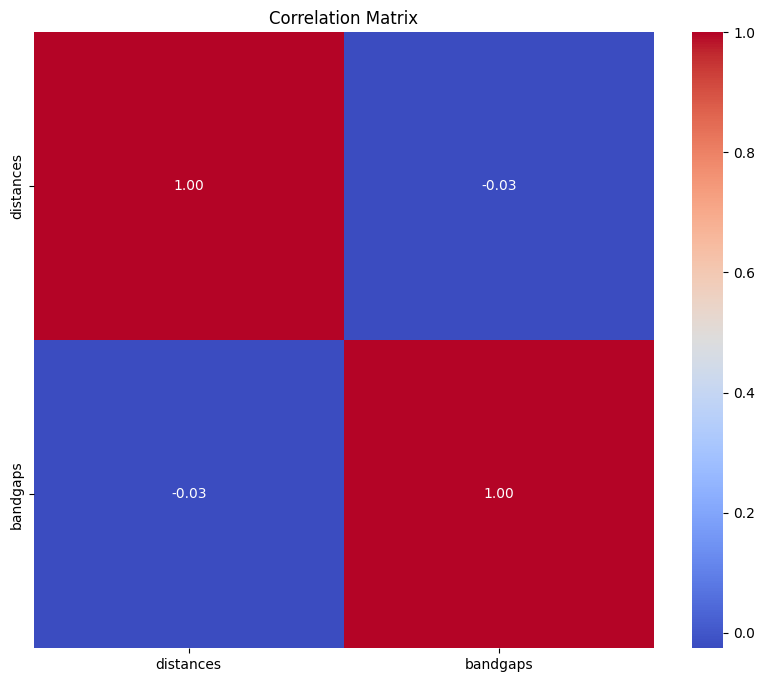

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

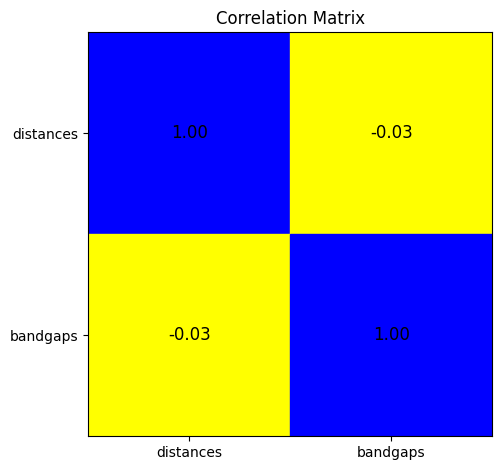

In [ ]:
# Compute correlation matrix
corr = df.corr()

# Extract values and labels
values = corr.values
labels = corr.columns.tolist()

# Create custom color matrix
colors = np.array([
    ['blue' if i == j else 'yellow' for j in range(2)]
    for i in range(2)
])

# Plot
fig, ax = plt.subplots()

for i in range(2):
    for j in range(2):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=colors[i][j]))
        ax.text(j + 0.5, i + 0.5, f"{values[i, j]:.2f}",
                ha='center', va='center', color='black', fontsize=12)

# Axis formatting
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()